<a href="https://colab.research.google.com/github/luisArthurRodriguesDaSilva/analise-eleicoes-brasileiras-2022/blob/master/apresenta%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# código
**caso queira apenas ver a análise pule para a sessão "análise" abaixo**

## 1 | importações de bibliotecas e recursos

In [9]:
import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
import cmath
import statistics
import pickle as pike

## 2 | Algumas relações para facilitar os plots da sessão 5 em diante

In [10]:
categoryKeys= ['Presidente', 'Senador', 'DeputadoFederal', 'DeputadoEstadual', 'Governador']
brasil_ufs = ['ac','al','am','ap','ba','ce','df','es','go','ma','mt','ms','mg','pa','pb','pr','pe','pi','rj','rn','ro','rs','rr','sc','se','sp','to']

LULA_TAG          = 'LULA' 
BOLSONARO_TAG     = 'JAIR BOLSONARO' 
CIRO_TAG          = 'CIRO GOMES' 
TEBET_TAG         = 'SIMONE TEBET' 
SORAYA_TAG        = 'SORAYA THRONICKE' 
DAVILA_TAG        =  "FELIPE D'AVILA"
PADRE_TAG         = 'PADRE KELMON' 
SOFIA_MANZANO_TAG = 'SOFIA MANZANO' 
LEO_PERICLES_TAG  ='LÉO PÉRICLES'
VERA_TAG          = 'VERA' 
EYMAEL_TAG        = 'CONSTITUINTE EYMAEL'
candidatesTags    = [LULA_TAG, BOLSONARO_TAG, CIRO_TAG, TEBET_TAG, SORAYA_TAG, DAVILA_TAG, PADRE_TAG, SOFIA_MANZANO_TAG, LEO_PERICLES_TAG, VERA_TAG, EYMAEL_TAG]
candidatesColors   =['red', 'green', 'blue','brown', 'green', 'blue','red', 'green', 'blue','green','yellow']
politicalColors = {}
for i, tag in enumerate(candidatesTags):
  politicalColors[tag] = candidatesColors[i]

## 3 | Obtenção do electionsData
### ele é um objeto mais organizado contendo todas as informações separadas por estado

você pode ver como ele foi construído [aqui](https://github.com/luisArthurRodriguesDaSilva/analise-eleicoes-brasileiras-2022/blob/master/notebooks/reunindoOsDados.ipynb)

In [11]:
pData = requests.get('https://github.com/luisArthurRodriguesDaSilva/analise-eleicoes-brasileiras-2022/blob/master/dados%20salvos/electionsData.pkl?raw=true',stream=True)
electionsData = (pike.load(pData.raw))

## 4 | Funções para exibição das informações desejadas

In [12]:
def getCandidateScore(uf,candidate, category, attr):
  keysArray = list(electionsData[uf][category].keys()[0:5].array)
  positionOtAttr = keysArray.index(attr)
  usedData = electionsData[uf][category].values
  candidateScore = list(filter(lambda x: x[0]== candidate,usedData))[0][positionOtAttr]
  return candidateScore

In [13]:
def getDiffBetweenTwoCandidates(uf, category='Presidente', candidates=[BOLSONARO_TAG , LULA_TAG], attr = '(%) Votos'):
  [candidateOne,candidateTwo] = candidates
  candidateOneScore = getCandidateScore(uf=uf,candidate= candidateOne, attr= attr,category=category )
  candidateTwoScore = getCandidateScore(uf=uf,candidate= candidateTwo, attr= attr,category=category )
  result = float(format(abs(candidateOneScore - candidateTwoScore),'.2f'))
  winer = candidateOne if candidateOneScore > candidateTwoScore else candidateTwo
  return result , winer

In [14]:
BIG_NUMBER = 9999999999
def separeDiferents(uf, usedFunc, candidates):
  acrecimo = 0 if usedFunc(uf)[1] ==  candidates[0] else BIG_NUMBER
  return usedFunc(uf)[0] + acrecimo

>função para gerar os graficos comparativos entre os candidatos de maneira genérica, dependendo apenas dos parametros

In [15]:
from matplotlib.colorbar import colors
def showDiffPerState(candidates, attr,category= 'Presidente',mode = 0, aditionalFuncs = [],ordenator='none'):
  usedFunc = lambda uf :  getDiffBetweenTwoCandidates(uf=uf,candidates=candidates, category=category, attr=attr)
  
  if mode == 0 :
    title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país'
    ordened_ufs = sorted(brasil_ufs,key=lambda uf: usedFunc(uf)[0])
  else:
    if mode == 1 :
      title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país separadamente'
      ordened_ufs = sorted(brasil_ufs,key=lambda uf: separeDiferents(uf=uf, usedFunc=usedFunc, candidates=candidates))
    else:
      title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país ordenados por {ordenator}'
      ordened_ufs = sorted(brasil_ufs,key=lambda uf: electionsData[uf][ordenator])

  [c1Color, c2color] = [politicalColors[candidates[0]],politicalColors[candidates[1]]]
  baseOrder = (list(map(lambda uf : usedFunc(uf)[0],ordened_ufs)))
  
  ylb = attr
  if attr == 'Votos':
    ylb = 'M votos'
    counts = (list(map(lambda x : float(format(abs(x/1000000),'.2f')),baseOrder)))
  else:
    counts = baseOrder
  bar_colors = list(map(lambda uf : f'tab:{c1Color}' if usedFunc(uf)[1] == candidates[0] else f'tab:{c2color}',ordened_ufs))

  fig, ax = plt.subplots()

  for func in aditionalFuncs:
    func(ax=ax,ordened_ufs=ordened_ufs)

  ax.bar(ordened_ufs, counts, color = bar_colors)
  ax.bar([0], [0], color = c1Color, label=f'onde {candidates[0]} ganhou') #metodo para conseguir colocar a legenda
  ax.bar([0 ],[0 ], color = c2color, label=f'onde {candidates[1]} ganhou')
  fig.set_size_inches(16,8)
  fig.patch.set_facecolor('xkcd:white')

  ax.set_ylabel(ylb)
  ax.set_xlabel('estados')
  ax.set_title(title)
  ax.legend()
  plt.rcParams.update({'font.size': 15})
  return plt.show

>Funções extras que podem adicionar mais informações ao showDiffPerState

In [16]:
def populacao(ax,ordened_ufs):
  counts = list(map(lambda uf: electionsData[uf]['populacao']/1500000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'blue', label=f'população 1.5M')
  ax.plot(ordened_ufs,counts, color = 'blue')

def pib(ax,ordened_ufs):
  counts = list(map(lambda uf: electionsData[uf]['pib']/100000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'orange', label=f'PIB (100000M R$)')
  ax.plot(ordened_ufs,counts, color = 'orange')

def pibPerCapta(ax,ordened_ufs):
  counts = list(map(lambda uf: electionsData[uf]['pib per-capta']*1000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'purple', label=f'pib per-capta parcial (1000 R$)')
  ax.plot(ordened_ufs,counts, color = 'purple')

def media(ax,ordened_ufs):
  pibsPerCapta = list(map(lambda uf: electionsData[uf]['pib per-capta']*1000,ordened_ufs))
  media = statistics.mean(pibsPerCapta)
  counts = list(map(lambda uf: media,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'cyan', label=f'media per capta')
  ax.plot(ordened_ufs,counts, color = 'cyan')
def verticalLine(uf,label):
  def vl(ax,ordened_ufs):
    ax.axvline(x = uf, color = 'black', label = label)
  return vl
  

def extremizeMedia(ax, ordened_ufs):
  moving_average = lambda x, w : np.convolve(x, np.ones(w), 'valid') / w
  extremes = np.array(list(map( lambda uf: getDiffBetweenTwoCandidates(uf = uf)[0],ordened_ufs)))
  MM = list(moving_average(extremes,5))
  #colors = list(map( lambda uf: politicalColors[getDiffBetweenTwoCandidates(uf = uf)[1]],ordened_ufs))
  ax.plot(ordened_ufs[len(ordened_ufs)-len(MM):],MM, color = 'b', label='MM(5) extremísmo')


# **Análise**

## Parte 1 | Contexto brasileiro



A seguir está o gráfico da diferença entre os candidatos (em porcentagem por cada região)

Podemos perceber a liderança do Piauí e Roraima respectivamente como o mais "lulistas" e "bolsonaristas" do país, entretanto a quantidade numérica de votos não expressa o mesmo


<function matplotlib.pyplot.show(close=None, block=None)>

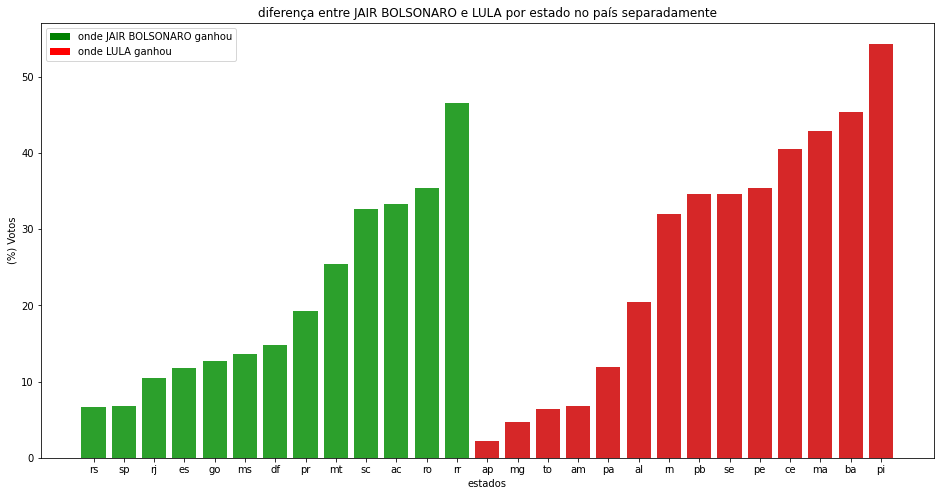

In [17]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 1)

Aqui podemos perceber que a expressividade proporcional do gráfico anterior engana

>Piauí (PI), mesmo sendo o que tem mais "lulistas" proporcionalmente, não foi o que conseguiu mais votos para lula, e sim a Bahia, que teve o segundo lugar nesse quesito

>São Paulo (SP) torna essa diferença ainda mais nítida, proporcionalmente ele é o segundo menos bolsonarista, mas é o que conseguiu mais voto para o candidato

<function matplotlib.pyplot.show(close=None, block=None)>

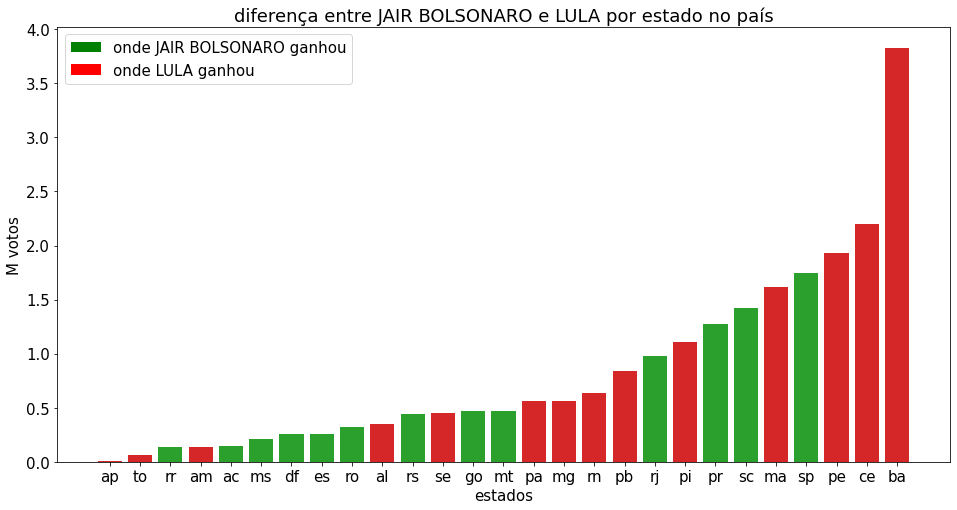

In [18]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='Votos',mode = 0)

visto que uma população suficientemente grande pode ultrapassar uma menor em números de votos, mesmo tendo poucos pontos percentuais contra uma grande vantagem, percebe-se que basta uma nação grande e decidida o suficiente para ofuscar grande parte dos estados menores e praticamente decidir a eleição


> entretanto, parece que algo impede isso como visto no gráfico abaixo


<function matplotlib.pyplot.show(close=None, block=None)>

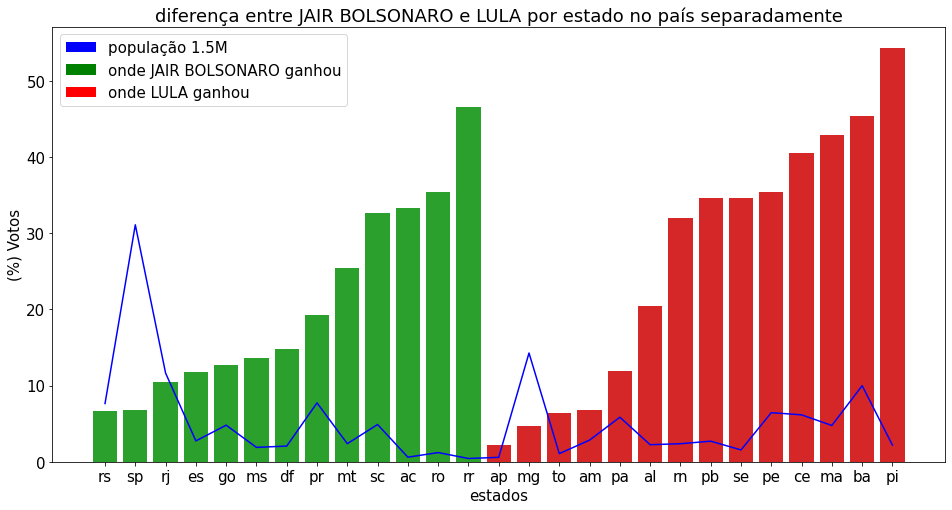

In [19]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 1, aditionalFuncs=[populacao])

>O gráfico acima nos mostra que quanto menor é a população, maior a tendência dela a um extremo

>Isso se assemelha a situação dos mercados de ações em que quanto menor o volume/valor de mercado maior é a volatilidade do ativo

>Aparentemente um maior número de pessoas/agentes funciona como um freio, onde quanto mais pessoas, mais difícil é para ordenar elas em uma mesma direção

Agora o segundo problema é, porque que esses respectivos estados preferem o Bolsonaro enquanto os outros o Lula, Será que há um dado numérico, que possa caracterizar o porquê de um ser lulista e o outro não?

Abaixo a comparação entre estados através do Pib (2019) e do PIB per capita parcial (Pib de 2019 / população de 2021 )


<function matplotlib.pyplot.show(close=None, block=None)>

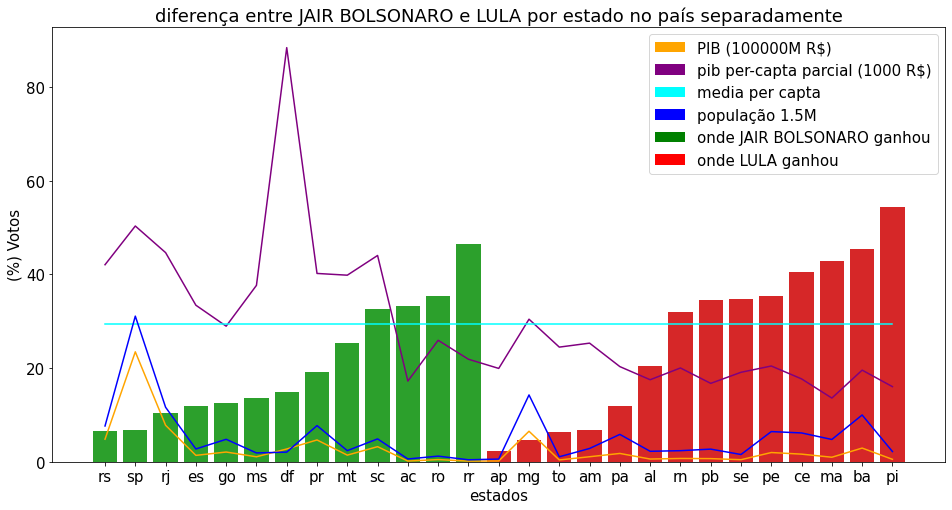

In [20]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 1, aditionalFuncs=[pib,pibPerCapta, media, populacao])

> ordenando por PIB para melhor visualização


<function matplotlib.pyplot.show(close=None, block=None)>

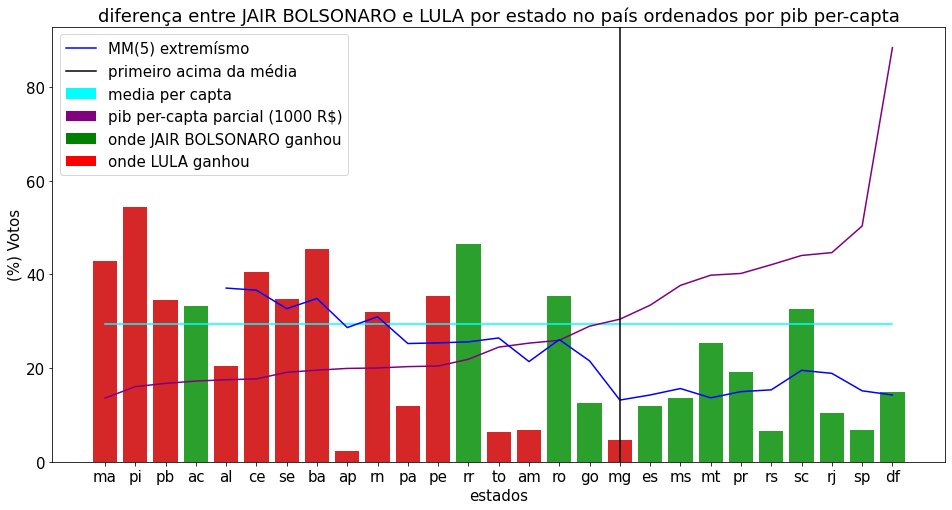

In [21]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 3, 
                 aditionalFuncs=[
                     media,pibPerCapta,extremizeMedia,
                     verticalLine('mg','primeiro acima da média')
                    ], ordenator='pib per-capta')

### conclusões

Aparentemente não há uma simples relação direta entre o quão bolsonarista/lulista um estado é de acordo com o seu respectivo Pib per capta, porém duas coisas podem ser constatadas

> 1 - Quanto menor o PIB per capita, maior é a **probabilidade** de preferência ao Lula, visto que dos 17 estados abaixo da média, ele venceu em 13, o mesmo para Bolsonaro, que venceu em 9 entre os 10 que estavam acima da média brasileira

> 2 - Assim como a população, quanto menor o PIB per capita maior é a tendência ao extremismo, visto que os 10 estados mais extremistas estão com o seu PIB abaixo da média brasileira

abaixo o gráfico das diferenças ordenados pelo extremismo


<function matplotlib.pyplot.show(close=None, block=None)>

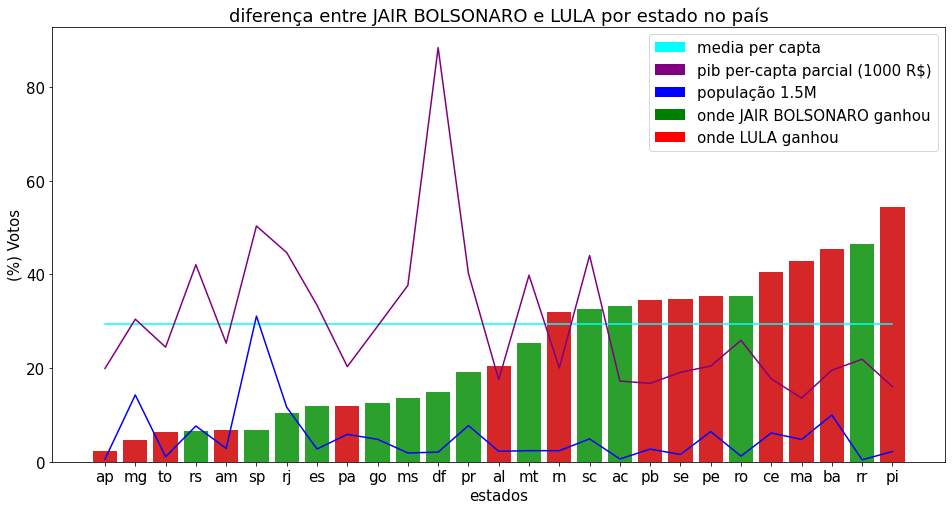

In [22]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 0,aditionalFuncs=[media,pibPerCapta, populacao, ])

Nos dados representados anteriormente, RR e PI tem se demonstrado muitos semelhantes, exceto pela diferença entre o candidato que escolheram


## parte 2 | Piauí e Roraima, os estados mais extremistas

A partir de agora o objetivo da análise é descobrir o porquê dessa diferença e o que pode estar relacionado com essa escolha

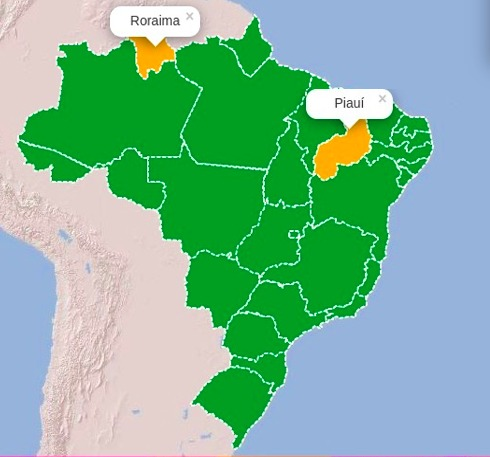

### Distribuição dos votos geograficamente
*veja também [esse notebook](https://github.com/luisArthurRodriguesDaSilva/analise-eleicoes-brasileiras-2022/blob/master/notebooks/mapa.ipynb)*

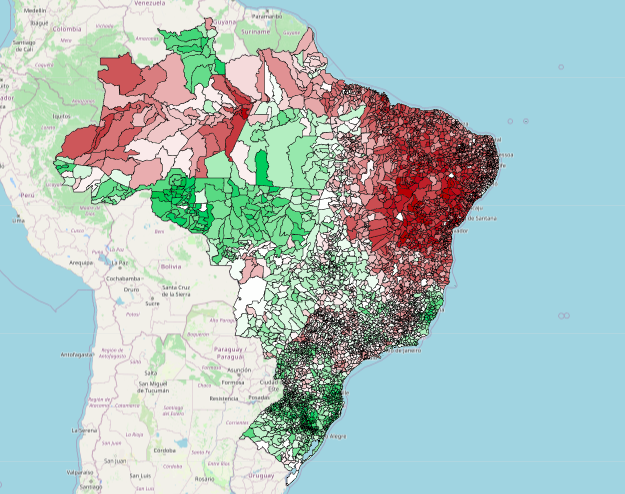

>O mapa acima nos mostra de maneira visual a distribuição de votos pelo país 
+verde = +Bolsonaro e +vermelho = +Lula


Observando o mapa, percebe-se que, do ponto geográfico, Piauí foi um estado extremamente coerente, diferente de Roraima, sendo "uma ilha verde no mar vermelho". Portanto, o Piauí não representa uma nenhuma grande anomalia a ser estudada, diferente de Roraima.

### Votos para prefeitos (2020)
*veja também esse notebook*

Abaixo os gráficos dos votos por partido das eleições para prefeitos e vereadores dos respectivos estados em 2020, os partidos estão separados por ideologias sendo:




```
azul -> centro
vermelho -> esquerda
verde -> direita
preto -> não definido
```

>as ideologias foram baseadas nesse [site](https://pt.m.wikipedia.org/wiki/Posicionamentos_dos_partidos_brasileiros)


RR prefeitos:

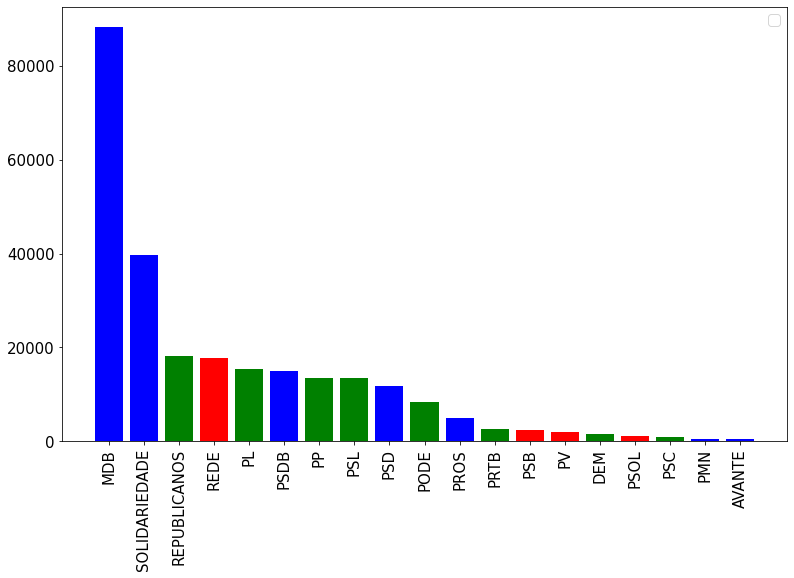

PI prefeitos:

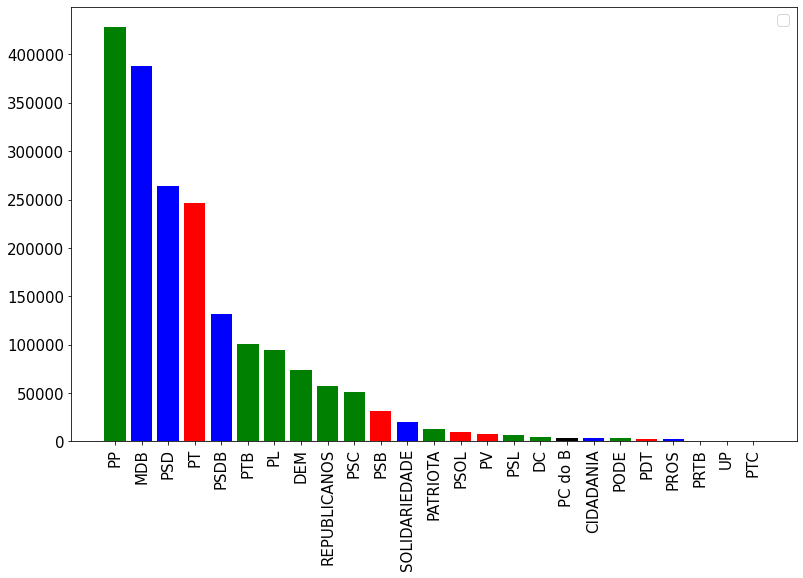

Observando esses gráficos, percebe se que não há uma ideologia predominante entre as regiões, e sim uma pequena diferença na preferência de partidos como:

>PT e PP que só estão entre as preferências no piauí

>SOLIDARIEDADE, que só é preferência em RORAIMA

Isso indica que essa análise dos votos para prefeitos foi praticamente inconclusiva, pois é perceptível uma pequena diferença nas preferências políticas, mas nada que justificasse toda essa discrepância.

### Busca nas mídias sociais

Devido a essa grande dificuldade de encontrar uma resposta sobre o bolsonarismo roraimense, resolvi buscar isso explicitamente pela internet para ver se encontrava respostas

Então encontrei:

esse [post do reddit](https://www.reddit.com/r/brasil/comments/xzo1pq/gente_como_explicar_porque_roraima_foi_ou_é_tão/?utm_source=share&utm_medium=web2x&context=3) onde os comentários muito mencionavam garimpos e invasões venezuelanas

esse [artigo](https://www.institutomillenium.org.br/por-que-bolsonaro-teve-quase-70-dos-votos-validos-em-roraima/) do instituto milenium que também muito aborda sobre a Venezuela e uma espécie de "medo do comunismo".

E essas reportagens da [veja](https://veja.abril.com.br/mundo/aloysio-nunes-ironiza-proposta-de-fechamento-da-fronteira-com-a-venezuela/) e do [poder360](https://www.poder360.com.br/brasil/dois-militares-venezuelanos-desertam-pela-fronteira-com-o-brasil/) reforçando a ideia sobre o impacto dos refugiados venezuelanos

<img src="https://static.poder360.com.br/2019/02/venezuela-fronteira-mapa-novo.jpg" width=500>

*fonte: Poder360*

### Conclusões:

Visto o que foi citado anteriormente e essas leituras podemos chegar as seguintes conclusões:




1.   A crise na Venezuela, somados aos refugiados vindos de la provavelmente, por ser um país comunista, gerou um grande medo ao povo roraimense sobre a esquerda, e isso trouxe essa discrepante preferência ao Bolsonaro.
2.   Piauí foi um estado bem coerente com os seus vizinhos, justificando o apoio ao Lula justo aos nordestinos.



